In [ ]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import datetime as dt
from flask import Flask, jsonify

# Reflect Tables into SQLAlchemy ORM

In [ ]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Calculate the date from the last(max) data point in the database
max_date = session.query(func.max(func.strftime("%Y-%m-%d", Measurement.date))).limit(5).all()
max_date[0][0]

'2017-08-23'

In [11]:
# Calculate the date 1 year ago from the last data point in the database
last_year = dt.date(2017, 8, 23) - dt.timedelta(days = 365)

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Perform a query to retrieve the data and precipitation scores
precip_data = (session
               .query(func.strftime("%Y-%m-%d", Measurement.date), Measurement.prcp)
               .filter(func.strftime("%Y-%m-%d", Measurement.date) >=last_year)).all()                  
precip_data

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42),
 ('2016-09-16', 0.06),
 ('2016-09-17', 0.05),
 ('2016-09-18', 0.0),
 ('2016-09-19', 0.0),
 ('2016-09-20', 0.0),
 ('2016-09-21', 0.0),
 ('2016-09-22', 0.02),
 ('2016-09-23', 0.0),
 ('2016-09-24', 0.0),
 ('2016-09-25', 0.0),
 ('2016-09-26', 0.06),
 ('2016-09-27', 0.02),
 ('2016-09-28', 0.0),
 ('2016-09-29', 0.0),
 ('2016-09-30', 0.0),
 ('2016-10-01', 0.0),
 ('2016-10-02', 0.0),
 ('2016-10-03', 0.0),
 ('2016-10-04', 0.0),
 ('2016-10-05', 0.0),
 ('2016-10-06'

In [13]:
last_year == dt.date(2016, 8, 23)

True

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip_data, columns = ["date", "precipitation"])
precip_df.set_index("date", inplace=True)

precip_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [15]:
# Sort the dataframe by date
precip_df = precip_df.sort_values(by='date')
precip_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


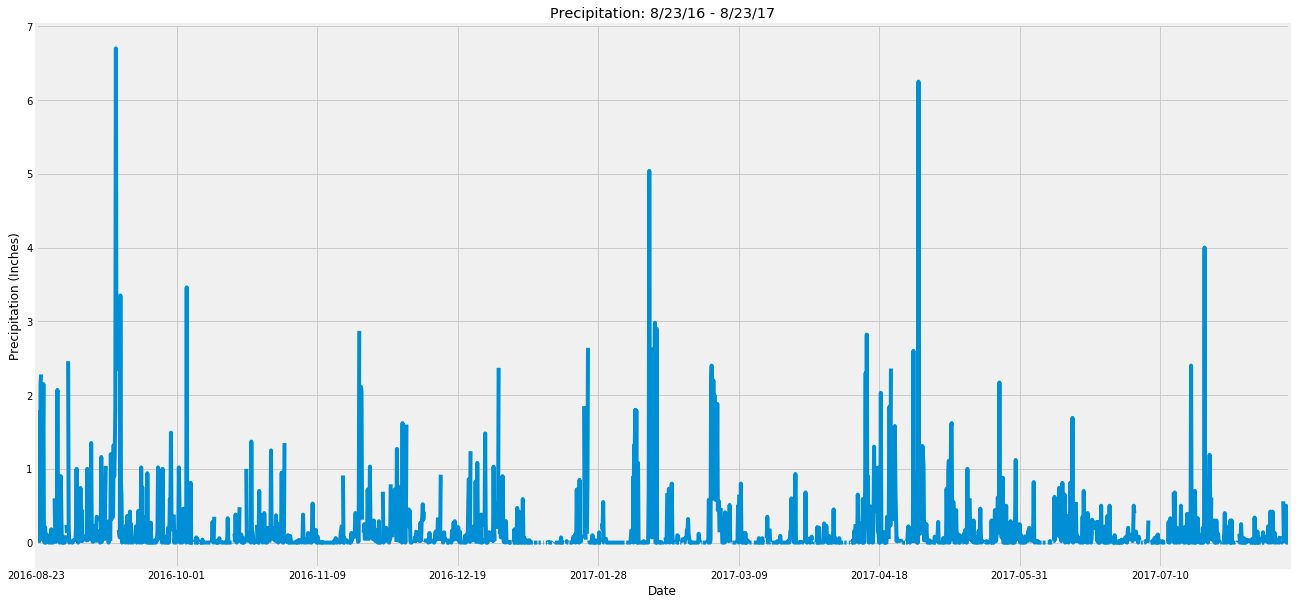

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize =(20,10))
precip_df.plot(ax= ax, legend=False, x_compat=True)
ax.set_title("Precipitation: 8/23/16 - 8/23/17")
ax.set_xlabel("Date")
ax.set_ylabel("Precipitation (Inches)")
plt.tight_layout
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# Design a query to show how many stations are available in this dataset?
station_data = (session
                .query(Station.station).count())
print(f"There are {station_data} stations in this dataset")

There are 9 stations in this dataset


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active = (session
              .query(Measurement.station, func.count(Measurement.station))
              .group_by(Measurement.station)
              .order_by(func.count(Measurement.station).desc()).all())
most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_id = 'USC00519281'
temps = (session
         .query(
             func.min(Measurement.tobs),
             func.max(Measurement.tobs),
             func.avg(Measurement.tobs))            
        .filter(Measurement.station == station_id).all()
        )
print(f"The Most Active Station ({station_id}) has Min: {temps[0][0]}(F), Max: {temps[0][1]}(F), and Avg: {round(temps[0][2],2)}(F) Temperatures")

The Most Active Station (USC00519281) has Min: 54.0(F), Max: 85.0(F), and Avg: 71.66(F) Temperatures


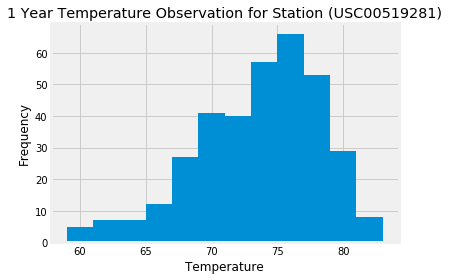

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_observation = (session
                    .query(Measurement.date, Measurement.tobs)
                    .filter(Measurement.station == station_id)
                    .filter(func.strftime("%Y-%m-%d", Measurement.date) >=last_year)).all()
temp_observation_df = pd.DataFrame(temp_observation, columns = ["date", "temperature"])
fig, ax = plt.subplots()
temp_observation_df.plot.hist(ax = ax, legend = False, bins = 12)
ax.set_xlabel("Temperature")
ax.set_ylabel("Frequency")
plt.title(f"1 Year Temperature Observation for Station ({station_id})")
plt.tight_layout()
plt.show()

## Bonus Challenge Assignment

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates


def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_dates = calc_temps('2017-06-01', '2017-06-15')
print(trip_dates)

[(72.0, 77.42268041237114, 83.0)]


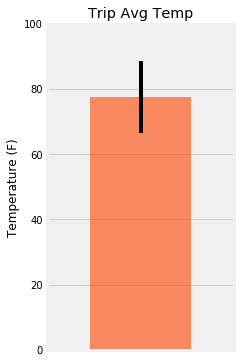

In [33]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

min_trip_temp = trip_dates[0][0]
avg_trip_temp = trip_dates[0][1]
max_trip_temp = trip_dates[0][2]


errorBar = max_trip_temp - min_trip_temp

plt.figure(figsize=(3,6))
plt.bar('trip_dates', avg_trip_temp, yerr=errorBar, color= 'orangered', alpha = .6)
plt.title('Trip Avg Temp')
plt.ylabel('Temperature (F)')
plt.ylim(0, 100)
plt.xlim(-0.75,.75)
plt.xticks([])
plt.show()

In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date = '2017-06-01'
end_date = '2017-06-15'

trps = (session
        .query(Station.station,
               Station.name,
               Station.latitude,
               Station.longitude,
               Station.elevation,
               func.sum(Measurement.prcp))
        .filter(Measurement.station == Station.station)
        .filter(Measurement.date >= start_date)
        .filter(Measurement.date <= end_date)
        .group_by(Station.station)
        .order_by(func.sum(Measurement.prcp).desc()).all())

for row in trps:    
    print(f"Station: {row[0]}\n   Location: {row[1]}\n   Latitude: {row[2]}  Longitude: {row[3]}\n   Elevation: {row[4]}\n   Rainfall: {row[5]}")
 

Station: USC00516128
   Location: MANOA LYON ARBO 785.2, HI US
   Latitude: 21.3331  Longitude: -157.8025
   Elevation: 152.4
   Rainfall: 5.51
Station: USC00519281
   Location: WAIHEE 837.5, HI US
   Latitude: 21.45167  Longitude: -157.84888999999998
   Elevation: 32.9
   Rainfall: 2.9800000000000004
Station: USC00514830
   Location: KUALOA RANCH HEADQUARTERS 886.9, HI US
   Latitude: 21.5213  Longitude: -157.8374
   Elevation: 7.0
   Rainfall: 2.02
Station: USC00513117
   Location: KANEOHE 838.1, HI US
   Latitude: 21.4234  Longitude: -157.8015
   Elevation: 14.6
   Rainfall: 1.96
Station: USC00519523
   Location: WAIMANALO EXPERIMENTAL FARM, HI US
   Latitude: 21.33556  Longitude: -157.71139
   Elevation: 19.5
   Rainfall: 0.76
Station: USC00519397
   Location: WAIKIKI 717.2, HI US
   Latitude: 21.2716  Longitude: -157.8168
   Elevation: 3.0
   Rainfall: 0.16
Station: USC00517948
   Location: PEARL CITY, HI US
   Latitude: 21.3934  Longitude: -157.9751
   Elevation: 11.9
   Rainfall

In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# Set the start and end date of the trip
start_date = '2017-06-01'
end_date = '2017-06-15'

# Use the start and end date to create a range of dates
start_trip = int(start_date[-2:])
end_trip = int(end_date[-2:])
trip_length = end_trip - start_trip +1

# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date
start_date = dt.datetime.strptime(start_date, '%Y-%m-%d')

date_list = [dt.datetime.strftime(start_date + dt.timedelta(days = x), '%m-%d')
            for x in range(0, trip_length)]

# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
trip_normals = [daily_normals(date) for date in date_list]

trip_normals

[[(64.0, 74.6140350877193, 81.0)],
 [(65.0, 74.4, 81.0)],
 [(65.0, 74.03448275862068, 80.0)],
 [(65.0, 73.81818181818181, 81.0)],
 [(68.0, 74.85454545454546, 81.0)],
 [(70.0, 75.17543859649123, 80.0)],
 [(68.0, 75.07142857142857, 81.0)],
 [(70.0, 75.58620689655173, 81.0)],
 [(69.0, 75.15254237288136, 81.0)],
 [(68.0, 75.14285714285714, 81.0)],
 [(69.0, 76.01960784313725, 84.0)],
 [(66.0, 75.66666666666667, 83.0)],
 [(68.0, 75.66666666666667, 81.0)],
 [(69.0, 75.62711864406779, 81.0)],
 [(67.0, 75.40350877192982, 81.0)]]

In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_normals = [np.array(normal[0]) for normal in trip_normals]

trip_normals_df = pd.DataFrame(trip_normals)
trip_normals_df["Date"] = date_list
trip_normals_df = trip_normals_df.set_index("Date")
trip_normals_df = trip_normals_df.rename(columns={0: "Low Temp", 1: "Avg Temp", 2: "High Temp"})
trip_normals_df

,Low Temp,Avg Temp,High Temp
Date,,,
06-01,64.0,74.614035,81.0
06-02,65.0,74.400000,81.0
06-03,65.0,74.034483,80.0
06-04,65.0,73.818182,81.0
06-05,68.0,74.854545,81.0
06-06,70.0,75.175439,80.0
06-07,68.0,75.071429,81.0
06-08,70.0,75.586207,81.0
06-09,69.0,75.152542,81.0


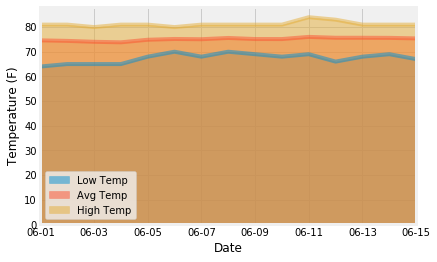

In [29]:
# Plot the daily normals as an area plot with `stacked=False`
trip_normals_df.plot.area(stacked=False, alpha=.5)
plt.ylabel("Temperature (F)")
plt.show()